In [238]:
import pandas as pd
from utils import get_engine
from dotenv import load_dotenv
from sqlalchemy import text
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [239]:
load_dotenv()
engine = get_engine(echo_arg=True)

In [240]:
with engine.begin() as conn:
    query = text("""SELECT * FROM "CO2_bulding_filtered_feauturs_selection"; """)
    df = pd.read_sql(query, conn)

2023-06-16 09:21:20,989 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-06-16 09:21:20,996 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:21:21,039 INFO sqlalchemy.engine.Engine select current_schema()
2023-06-16 09:21:21,044 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:21:21,088 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-06-16 09:21:21,092 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-16 09:21:21,149 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-16 09:21:21,162 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [241]:
y = df['TotalGHGEmissions']

In [242]:
X_cols = ['YearBuilt', 'ENERGYSTARScore', 'Have_Energy',
       'Have_Stream_Energy', 'Have_Electricity_Energy',
       'Have_NaturalGas_Energy', 'BuildingType', 'PrimaryPropertyType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Address', 
       'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding_s_', 'LargestPropertyUseTypeGFA']

In [243]:
X = df[X_cols]

In [244]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [245]:
bool_cols = ['Have_Energy', 'Have_Stream_Energy', 'Have_Electricity_Energy','Have_NaturalGas_Energy']
X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))

/tmp/ipykernel_239762/2468965264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))


In [246]:
X_cat = X.select_dtypes(include=[object])
X_num = X.select_dtypes(exclude=[object])
gb = HistGradientBoostingRegressor()
xgb = XGBRegressor(objective='reg:squarederror')
ridge = Ridge()

preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X_cat.columns),
    ('tf_num', RobustScaler(), X_num.columns)
])
pipe_gb = Pipeline(steps=[
    ('preparation', preparation),
    ('model', gb)
])

pipe_xgb = Pipeline(steps=[
    ('preparation', preparation),
    ('model', xgb)
])

pipe_ridge = Pipeline(steps=[
    ('preparation', preparation),
    ('model', ridge)
])

In [247]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [248]:
params_gbc = {'model__max_iter': [300, 400, 500]}
params_xbc = {'model__max_depth': [8, 9, 10]}
params_ridge = {'model__solver': ['auto', 'svd']}

In [249]:
pipe_list = [pipe_gb, pipe_ridge, pipe_xgb]
params_list = [params_gbc, params_ridge, params_xbc]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[CV] END ................................model__max_iter=300; total time= 3.8min
[CV] END ................................model__max_iter=300; total time= 3.9min
[CV] END ................................model__max_iter=300; total time= 3.9min
[CV] END ................................model__max_iter=300; total time= 3.9min
[CV] END ................................model__max_iter=300; total time= 4.7min
[CV] END ................................model__max_iter=400; total time= 5.1min
[CV] END ................................model__max_iter=400; total time= 5.3min
[CV] END ................................model__max_iter=400; total time= 6.3min
[CV] END ................................model__max_iter=400; total time= 4.6min
[CV] END ................................model__max_iter=400; total time= 4.8min
[CV] END ................................model__max_iter=500; total time= 5.6min
[CV] END ................................model__max_iter=500; total time= 6.0min
[CV] END ...................

2023/06/16 09:33:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: '/home/dakoro/Data_IA/TP/CO2_Manuel_David/mlruns' does not exist.


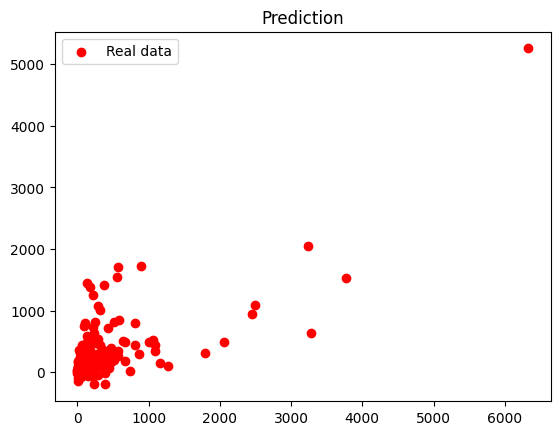

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................model__solver=auto; total time=   3.0s
[CV] END .................................model__solver=auto; total time=   4.1s
[CV] END .................................model__solver=auto; total time=   4.4s
[CV] END .................................model__solver=auto; total time=   4.9s
[CV] END .................................model__solver=auto; total time=   5.3s
[CV] END ..................................model__solver=svd; total time=  30.2s
[CV] END ..................................model__solver=svd; total time=  29.1s
[CV] END ..................................model__solver=svd; total time=  28.1s
[CV] END ..................................model__solver=svd; total time=  33.8s
[CV] END ..................................model__solver=svd; total time=  28.5s


2023/06/16 09:34:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: '/home/dakoro/Data_IA/TP/CO2_Manuel_David/mlruns' does not exist.


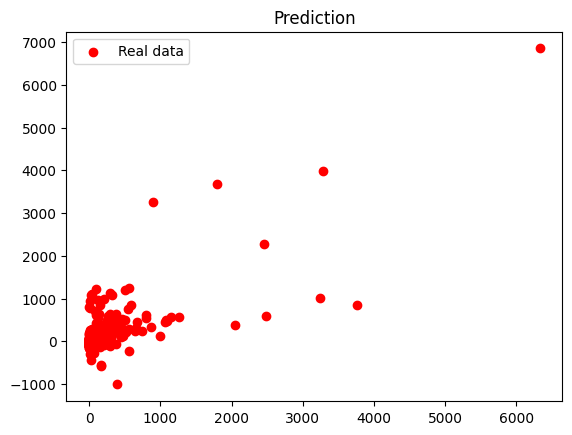

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .................................model__max_depth=8; total time= 2.7min
[CV] END .................................model__max_depth=8; total time= 2.7min
[CV] END .................................model__max_depth=8; total time= 2.7min
[CV] END .................................model__max_depth=8; total time= 2.7min
[CV] END .................................model__max_depth=8; total time= 2.8min
[CV] END .................................model__max_depth=9; total time= 2.9min
[CV] END .................................model__max_depth=9; total time= 3.1min
[CV] END .................................model__max_depth=9; total time= 3.1min
[CV] END .................................model__max_depth=9; total time= 2.8min
[CV] END .................................model__max_depth=9; total time= 2.8min
[CV] END ................................model__max_depth=10; total time= 3.0min
[CV] END ................................model__m

2023/06/16 09:40:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: '/home/dakoro/Data_IA/TP/CO2_Manuel_David/mlruns' does not exist.


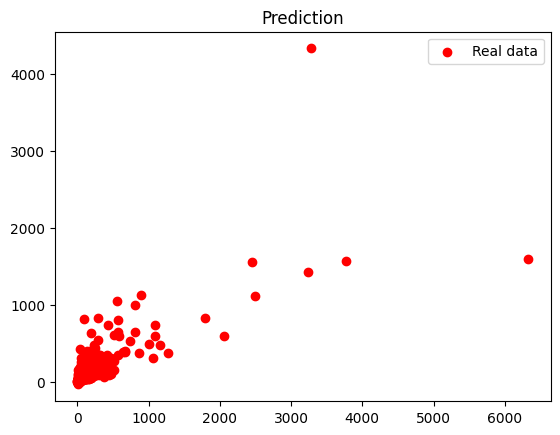

In [250]:
from sklearn.metrics import r2_score
result = []
for pipe, param in zip(pipe_list, params_list):
    grid = GridSearchCV(pipe, param, scoring='r2', cv=5, n_jobs=-1, verbose=2)
    model = grid.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.append(r2_score(y_test, y_pred))
    plt.scatter(y_test, y_pred, color = 'red', label = 'Real data')
    plt.title('Prediction')
    plt.legend()
    plt.show()

In [251]:
for item in result:
    print(item)

0.5805305120523092
0.4849321563783703
0.5794233482578544


In [252]:
df = df.dropna()
X = df[X_cols]
X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))
y = df['SiteEUI_kBtu_sf_']

/tmp/ipykernel_239762/4080895302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols]= X[bool_cols].apply(lambda x: x.apply(lambda x: 1 if x else 0))


In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[CV] END ................................model__max_iter=300; total time= 3.8min
[CV] END ................................model__max_iter=300; total time= 3.9min
[CV] END ................................model__max_iter=300; total time= 4.0min
[CV] END ................................model__max_iter=300; total time= 4.2min
[CV] END ................................model__max_iter=300; total time= 4.3min
[CV] END ................................model__max_iter=400; total time= 5.4min
[CV] END ................................model__max_iter=400; total time= 5.9min
[CV] END ................................model__max_iter=400; total time= 6.1min
[CV] END ................................model__max_iter=400; total time= 5.2min
[CV] END ................................model__max_iter=400; total time= 5.0min
[CV] END ................................model__max_iter=500; total time= 5.6min
[CV] END ................................model__max_iter=500; total time= 5.8min
[CV] END ...................

2023/06/16 09:54:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: '/home/dakoro/Data_IA/TP/CO2_Manuel_David/mlruns' does not exist.


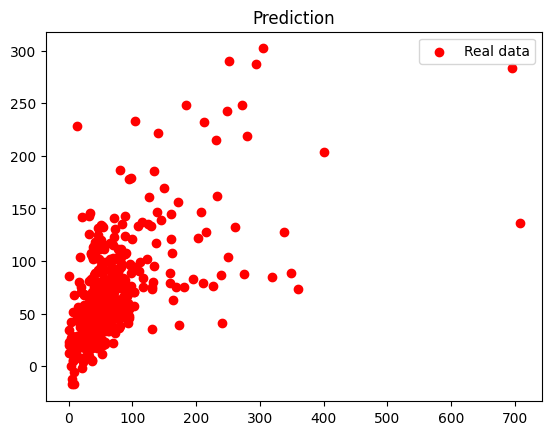

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................model__solver=auto; total time=   3.0s
[CV] END .................................model__solver=auto; total time=   3.1s
[CV] END .................................model__solver=auto; total time=   3.2s
[CV] END .................................model__solver=auto; total time=   3.5s
[CV] END .................................model__solver=auto; total time=   3.7s
[CV] END ..................................model__solver=svd; total time=  27.1s
[CV] END ..................................model__solver=svd; total time=  25.7s
[CV] END ..................................model__solver=svd; total time=  24.1s
[CV] END ..................................model__solver=svd; total time=  29.3s
[CV] END ..................................model__solver=svd; total time=  32.3s


2023/06/16 09:55:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: '/home/dakoro/Data_IA/TP/CO2_Manuel_David/mlruns' does not exist.


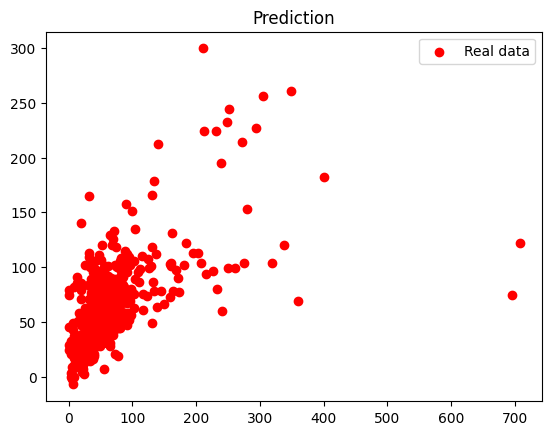

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [254]:
from sklearn.metrics import r2_score
result = []
for pipe, param in zip(pipe_list, params_list):
    grid = GridSearchCV(pipe, param, scoring='r2', cv=5, n_jobs=-1, verbose=2)
    model = grid.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result.append(r2_score(y_test, y_pred))
    plt.scatter(y_test, y_pred, color = 'red', label = 'Real data')
    plt.title('Prediction')
    plt.legend()
    plt.show()

In [ ]:
for item in result:
    print(item)

0.3998399281626386
0.37900575625674393
0.46395107505662514
